<a href="https://colab.research.google.com/github/nnanna217/msc-image-search/blob/main/BOVW_base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing BoVW


#### Import a dataset of images to train the model.






In [ ]:
# !pip install datasets opencv-contrib-python opencv-python

In [ ]:
from datasets import load_dataset

# dataset = load_dataset("ldhnam/deepfashion_controlnet_ezcaption")
# download the dataset
imagenet = load_dataset("ldhnam/deepfashion_controlnet_ezcaption")
imagenet

Found cached dataset parquet (/home/lunet/conce/.cache/huggingface/datasets/ldhnam___parquet/ldhnam--deepfashion_controlnet_ezcaption-55a40c6805eeee14/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'openpose', 'cloth', 'caption'],
        num_rows: 13670
    })
    test: Dataset({
        features: ['image', 'openpose', 'cloth', 'caption'],
        num_rows: 9
    })
})

#### Visualize some images

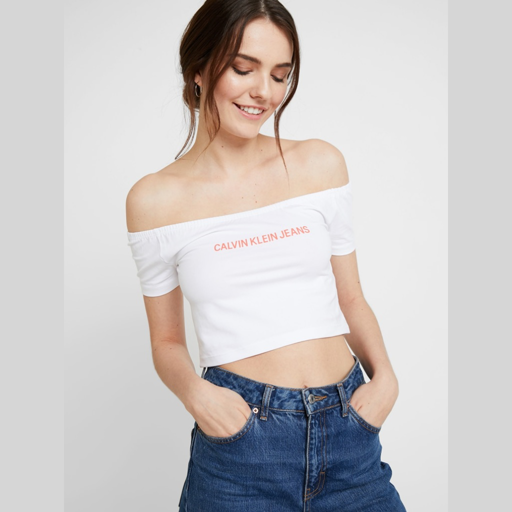

In [ ]:
imagenet['train'][10]['image']


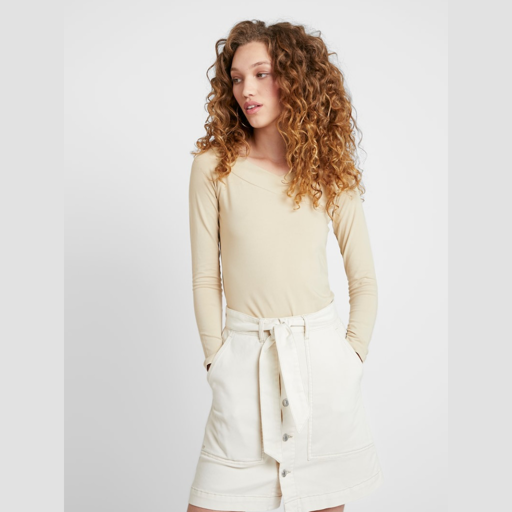

In [ ]:
imagenet['train'][5874]['image']

#### Convert images from PIL objects to numpy arrays

In [ ]:
from PIL import Image

# Check if an object is a PIL image
if isinstance(imagenet['train'][0]['image'], Image.Image):
    print("The object is a PIL image.")
else:
    print("The object is not a PIL image.")

The object is a PIL image.


In [ ]:
import numpy as np

# initialize list
images_training = []

for n in range(0,len(imagenet['train'])):
    # generate np arrays from the dataset images
    images_training.append(np.array(imagenet['train'][n]['image']))


#### Transform color images to grayscale

In [ ]:
#!pip install opencv-contrib-python opencv-python

In [ ]:
import cv2 as cv

# convert images to grayscale
bw_images = []
for img in images_training:
    # if RGB, transform into grayscale
    if len(img.shape) == 3:
        bw_images.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    else:
        # if grayscale, do not transform
        bw_images.append(img)


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(bw_images[10], cmap='gray')
plt.show()

#### Extract Visual features

###### Using SIFT

Step 1 - Extract the images visual features (i.e keypoints & descriptors) using SIFT

In [ ]:
# defining feature extractor that we want to use (SIFT)
extractor = cv.xfeatures2d.SIFT_create()

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

for img in bw_images:
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)


[ WARN:0@2.543] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


In [ ]:
print("------ Keypoints--------")
for k in keypoints[:20]:
  print(np.array(k).shape)

print("------ Descriptors--------")
for d in descriptors[:20]:
  print(np.array(d).shape)

Check extracted keypoints, and filter outkeypoints with None

In [ ]:
print(f"len before: {len(descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"len after: {len(descriptors)}")

len before: 13670
indexes: []
len after: 13670


Visualize some images with extracted features

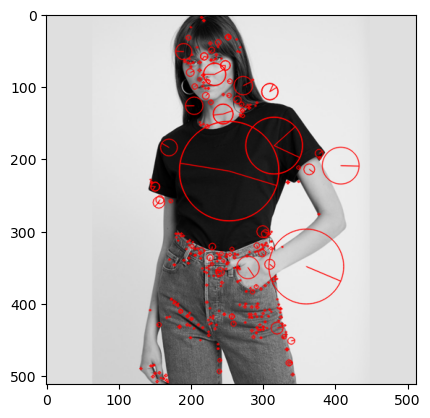

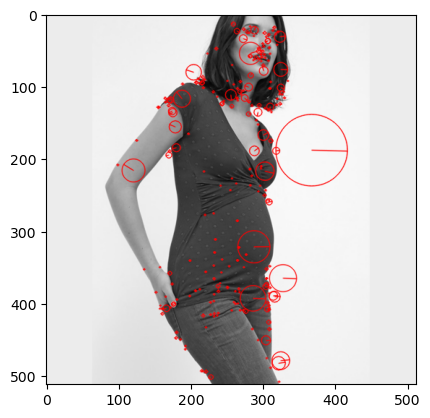

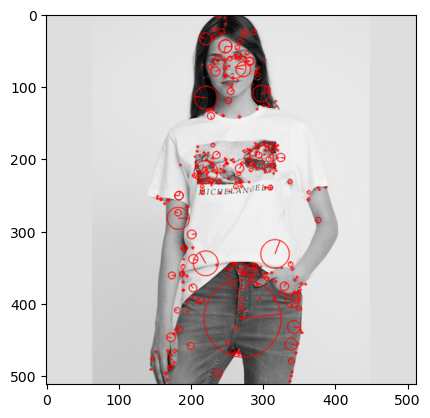

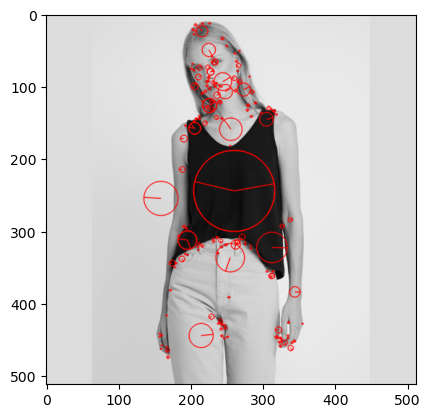

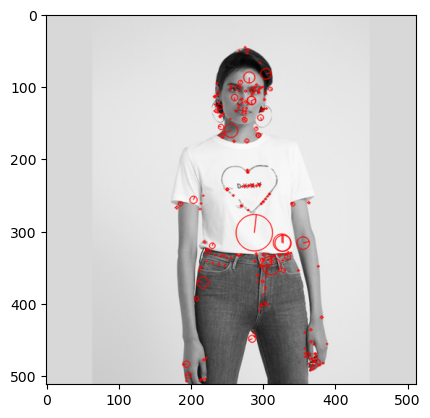

In [ ]:
output_image = []
for x in range(5):
    output_image.append(cv.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()

#### Build Codebook

In [ ]:
# set numpy seed for reproducability
# select the same numbers in each run
np.random.seed(0)
# select 1000 random image index values
sample_idx = np.random.randint(0, len(imagenet)+1, 1000).tolist()

# extract the sample from descriptors
# (we don't need keypoints)
descriptors_sample = []

for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))


In [ ]:
all_descriptors = []
# extract image descriptor lists
for img_descriptors in descriptors_sample:
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

In [ ]:
# check the shape
all_descriptors.shape

(320148, 128)

Get aggregated stats of the extracted features from the images dataset

In [ ]:
# we can count the number of descriptors contained in descriptors to confirm
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
# here we can see the number of descriptors for the first five images
print(f"first five: {count[:5]}")
# and if we sum them all, we should see the 39893 from before
print(f"count all: {sum(count)}")

first five: [349, 257, 349, 257, 257]
count all: 320148


 Group similar visual features (descriptors) using k-means

---



In [ ]:
# perform k-means clustering to build the codebook
from scipy.cluster.vq import kmeans

k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)


In [ ]:
codebook.shape

(185, 128)

Save codebook for reuse

In [ ]:
#!pip install joblib

In [ ]:
import joblib

# save number of clusters and codebook
# Joblib dumps Python object into one file
joblib.dump((k, codebook), "bovw-codebook.pkl", compress=3)

['bovw-codebook.pkl']

In [ ]:
# Code bit to load a built visual words codebook for future use.
# load the visual features, number of clusters, and codebook
# k, codebook = joblib.load("bovw-codebook.pkl")

#### Build Sparse Vectors

 Building the sparse vector representations of our images, requires three steps

1.   Vector Quantization
2.   Frequency count
3.   Tf-idf






###### Step 1 - Vector Quantization

Transform the visual features into visual words

In [ ]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [ ]:
visual_words[0][:10], len(visual_words[0])

(array([ 56,  16, 177,  11,  54,  92,  36, 147,  62,  18], dtype=int32), 349)

#### Step 2 - Frequency Count

In [ ]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [ ]:
frequency_vectors.shape

(13670, 200)

In [ ]:
# we know from above that ids 84, 22, 45, and 172 appear in image 0
for i in [ 87, 131, 144,  67,  94, 164, 182, 175,  53, 109]:
    print(f"{i}: {frequency_vectors[0][i]}")

87: 6.0
131: 1.0
144: 3.0
67: 2.0
94: 2.0
164: 1.0
182: 6.0
175: 2.0
53: 1.0
109: 0.0


In [ ]:
frequency_vectors[0][:20]

array([0., 3., 7., 0., 1., 1., 1., 1., 1., 1., 1., 5., 1., 0., 3., 3., 6.,
       0., 7., 2.])

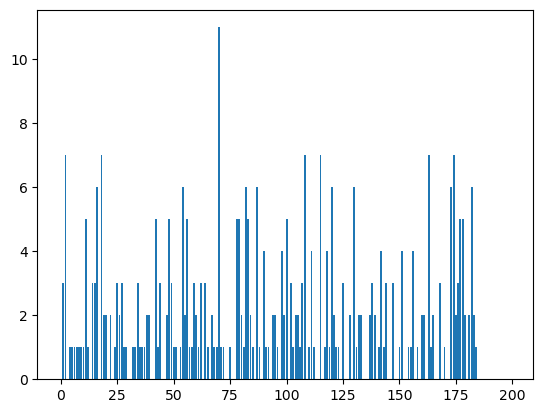

In [ ]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

#### Tf-idf

In [ ]:
# N is the number of images, i.e. the size of the dataset
N = len(images_training)

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)

In [ ]:
df.shape, df[:5]

((200,), array([ 6535, 11733, 11185,   498, 12150]))

In [ ]:
idf = np.log(N/ df)
idf.shape, idf[:5]

/tmp/ipykernel_7616/2983987240.py:1: RuntimeWarning: divide by zero encountered in divide
  idf = np.log(N/ df)


((200,), array([0.7380313 , 0.15279827, 0.20063006, 3.31235885, 0.11787448]))

In [ ]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[0][:5]

/tmp/ipykernel_7616/1349237404.py:1: RuntimeWarning: invalid value encountered in multiply
  tfidf = frequency_vectors * idf


((13670, 200),
 array([0.        , 0.4583948 , 1.40441039, 0.        , 0.11787448]))

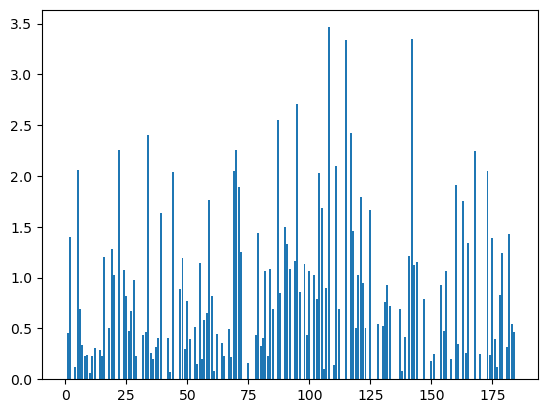

In [ ]:
# we can visualize the histogram for image 0 again
plt.bar(list(range(k)), tfidf[0])
plt.show()

#### Search

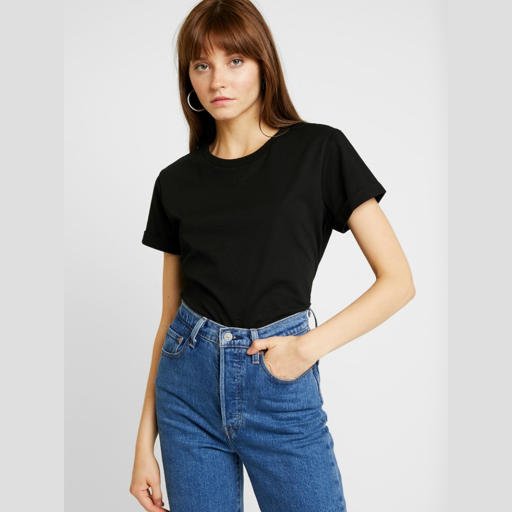

In [ ]:
i = 0
imagenet['train'][i]['image']


0: nan


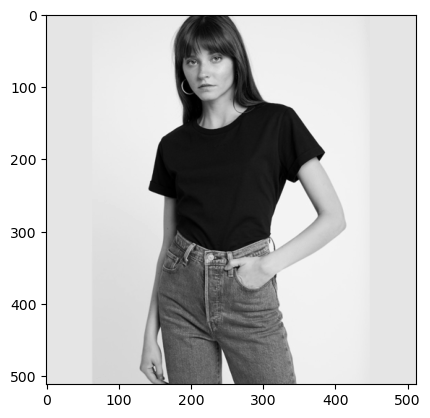

9107: nan


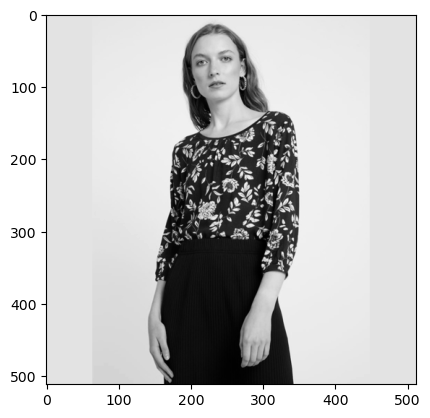

9108: nan


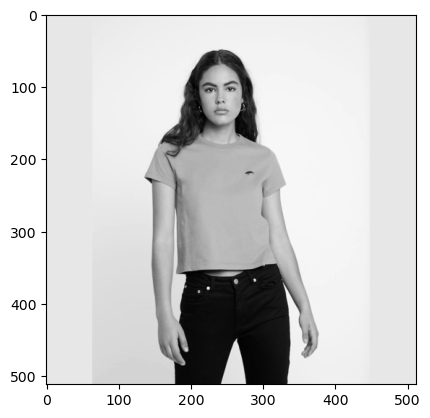

9109: nan


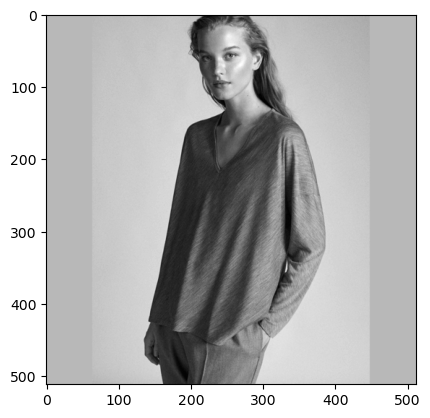

9110: nan


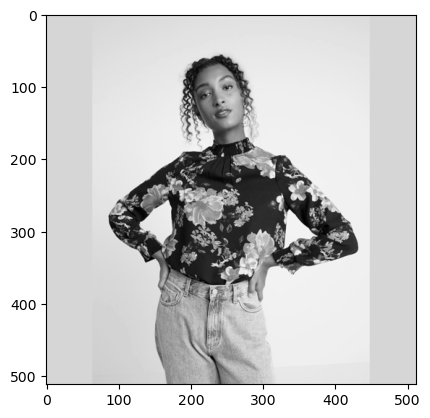

In [ ]:
from numpy.linalg import norm

top_k = 5

# get search image vector
a = tfidf[i]
b = tfidf  # set search space to the full sample
# get the cosine distance for the search image `a`
cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
# get the top k indices for most similar vecs
idx = np.argsort(-cosine_similarity)[:top_k]
# display the results
for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)}")
    plt.imshow(bw_images[i], cmap='gray')
    plt.show()